In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
path = './data/'
p1= pd.read_csv(path+'users.csv')
p2= pd.read_csv(path+'books.csv')
p3= pd.read_csv(path+'train_ratings.csv')
p4= pd.read_csv(path+'sample_submission.csv')
p5= pd.read_csv(path+'test_ratings.csv') # test와 sample은 완벽하게 동일하다.

#조금 전처리됨
p6= pd.read_csv('/opt/ml/input/code/pre_users.csv')

users  =p6.copy()
books  =p2.copy()
train  =p3.copy()
sample =p4.copy()
test   =p5.copy()

print('users shape: ', users.shape) 
print(users.columns)#유저id, 지역, 나이
print('books shape: ', books.shape)
print(books.columns)#isbn(책번호), 제목, 저자, 출판년도, 출판사, img주소, 언어, 범주, 요약, img경로
print('train shape: ', train.shape) 
print(train.columns)# 유저 id, 책isbn, 평점

users shape:  (68092, 5)
Index(['user_id', 'age', 'city', 'state', 'country'], dtype='object')
books shape:  (149570, 10)
Index(['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher',
       'img_url', 'language', 'category', 'summary', 'img_path'],
      dtype='object')
train shape:  (306795, 3)
Index(['user_id', 'isbn', 'rating'], dtype='object')


In [2]:
#re.sub(정규표현식, 치환 문자, 대상 문자열) replace해준다.
#\W는 알파벳, 숫자, _가 아닌 모든 문자, 즉 특수문자! +는 반복이 있을 수 있다는 것을 뜻한다.
books.loc[books[books['category'].notnull()].index, 'category'] = \
	books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip())
books['category'] = books['category'].str.lower()
books['category'] = books['category'].fillna('1')
books.drop(columns=['img_url', 'img_path'], inplace=True, errors='ignore')
# print(books.sample(5))
train = pd.merge(train, users)
train = pd.merge(train, books)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306795 entries, 0 to 306794
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              306795 non-null  int64  
 1   isbn                 306795 non-null  object 
 2   rating               306795 non-null  int64  
 3   age                  214133 non-null  float64
 4   city                 299787 non-null  object 
 5   state                298103 non-null  object 
 6   country              300283 non-null  object 
 7   book_title           306795 non-null  object 
 8   book_author          306795 non-null  object 
 9   year_of_publication  306795 non-null  float64
 10  publisher            306795 non-null  object 
 11  language             187711 non-null  object 
 12  category             306795 non-null  object 
 13  summary              187711 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 35.1+ MB


In [3]:
tmp = train['category'].value_counts().to_dict()
train_category = pd.DataFrame(list(tmp.items()), columns=('category', 'count'))
category_one = train_category[train_category['count'] == 1]
category_one

,category,count
1873,holy spirit,1
1874,pregnancy,1
1875,evolution,1
1876,dayton tenn,1
1877,unix computer file,1
...,...,...
3711,hasidim,1
3712,aggada,1
3713,american loyalists,1
3714,chemical industry,1


In [4]:
tmp = books['category'].value_counts().to_dict()
books_category = pd.DataFrame(list(tmp.items()), columns=('category', 'count'))


In [5]:
tmp_category = books['category'].copy()
categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india',
 'history']

for category in categories:
	tmp_category=tmp_category.where(tmp_category.str.contains(category) == False, category)
tmp_category.str.contains('fiction')

0         False
1         False
2         False
3          True
4         False
          ...  
149565    False
149566    False
149567    False
149568     True
149569    False
Name: category, Length: 149570, dtype: bool

In [6]:
print(tmp_category[tmp_category.str.contains('animal')].count())
print(tmp_category[tmp_category.str.contains('bird')].count())

224
26


In [7]:
#차라리 직접 범주 분류를 해보자. 
#학습셋과 책셋에서의 상위권들을 보고 비교해보자. 
tmp = [1, 5, 10, 20, 30, 40, 50, 100, 200]
for i in tmp:
	print(f'책 데이터 상위 {i}개의 범주의 지분')
	print(books_category[:i]['count'].sum() / books_category['count'].sum())
# books_category[:50]

책 데이터 상위 1개의 범주의 지분
0.4603262686367587
책 데이터 상위 5개의 범주의 지분
0.7551982349401618
책 데이터 상위 10개의 범주의 지분
0.8002674333088187
책 데이터 상위 20개의 범주의 지분
0.8533395734438725
책 데이터 상위 30개의 범주의 지분
0.8853045396804172
책 데이터 상위 40개의 범주의 지분
0.9064585144079695
책 데이터 상위 50개의 범주의 지분
0.9166610951393996
책 데이터 상위 100개의 범주의 지분
0.9359430367052216
책 데이터 상위 200개의 범주의 지분
0.949080698000936


In [8]:
#잊지말자. 책 데이터를 정제한다면 이후에는 학습데이터에도 반영해줘야한다.
books['high_category'] = books['category'].copy()

In [9]:
print('juvenile fiction',train[train['category'] =='juvenile fiction']['rating'].describe()[:3])
print('juvenile nonfiction',train[train['category'] =='juvenile nonfiction']['rating'].describe()[:3])
#소설 비소설보다는 청소년용인게 중요하지 않을까?

juvenile fiction count    12099.000000
mean         7.519712
std          2.383750
Name: rating, dtype: float64
juvenile nonfiction count    1660.000000
mean        7.323494
std         2.557274
Name: rating, dtype: float64


In [10]:
#쳥소년용은 청소년용으로 퉁치기
lst = ['juvenile', 'young adult']
lst = '|'.join(lst)
books['high_category'].where(books['high_category'].str.contains(lst)==False, 'juvenile', inplace=True)


In [11]:
books['high_category'].value_counts() # 효과적으로 합쳐졌다.

1                                                  68851
fiction                                            33016
juvenile                                            7318
biography autobiography                             3326
history                                             1927
                                                   ...  
gone with the wind motion picture 1939                 1
disguise                                               1
country lawyers                                        1
humorous stories brazilian                             1
authors canadian english 20th century biography        1
Name: high_category, Length: 4094, dtype: int64

In [12]:
# books[books['category'].str.contains('crim')]

# 잠시 실험. k-동건 클러스터링 말고 다른 방법이 있는가?

/tmp/ipykernel_86700/3342971300.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()
/tmp/ipykernel_86700/3342971300.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


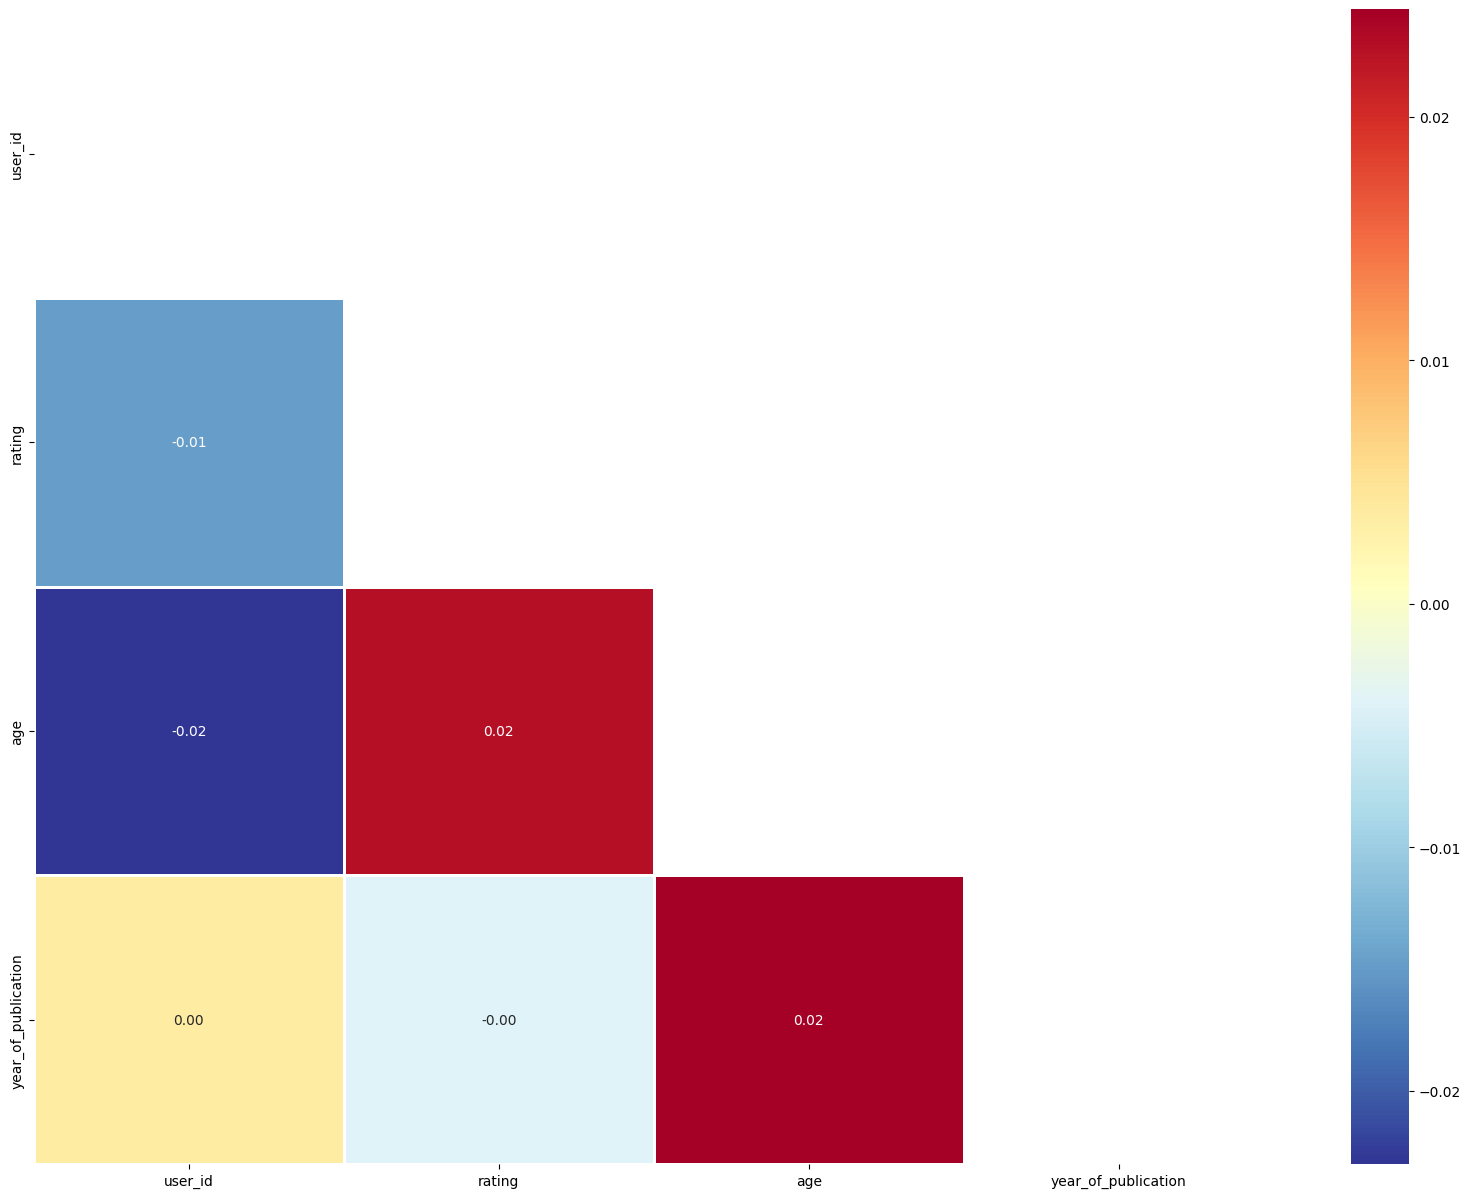

In [13]:
corr = train.corr()

plt.figure(figsize=(20,15))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(data = corr, annot = True, mask=mask, fmt='.2f', linewidths=1., cmap='RdYlBu_r')
plt.show()

In [14]:
!pip install kmodes
#이게 진짜 맞다니

In [15]:
tmp = books.drop(columns=['language', 'summary'], errors='ignore')
tmp

,isbn,book_title,book_author,year_of_publication,publisher,category,high_category
0,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,actresses,actresses
1,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,1940 1949,1940 1949
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,medical,medical
3,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,fiction,fiction
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000.0,Berkley Publishing Group,history,history
...,...,...,...,...,...,...,...
149565,067161746X,The Bachelor Home Companion: A Practical Guide...,P.J. O'Rourke,1987.0,Pocket Books,humor,humor
149566,0767907566,All Elevations Unknown: An Adventure in the He...,Sam Lightner,2001.0,Broadway Books,nature,nature
149567,0884159221,Why stop?: A guide to Texas historical roadsid...,Claude Dooley,1985.0,Lone Star Books,1,1
149568,0912333022,The Are You Being Served? Stories: 'Camping In...,Jeremy Lloyd,1997.0,Kqed Books,fiction,fiction


In [16]:
# from kmodes.kmodes import KModes
# cost = []
# K = range(1, 7)
# for num in K:
#     kmode = KModes(n_clusters = num, n_init = 3)
#     kmode.fit_predict(tmp)
#     cost.append(kmode.cost_)

# plt.plot(K, cost, 'bx-')
# plt.xlabel('number of clusters')
# plt.ylabel('cost')
# plt.title('elbow method for finding optimal K')
# plt.show()

In [17]:
# kmode = KModes(n_clusters = 20, n_init = 3)
# clusters = kmode.fit_predict(tmp)
# tmp['clusters'] = clusters

In [18]:
# lst = [0, 5, 10, 15]
# for i in lst:
# 	print(i, '번째 클러스터')
# 	print(tmp[tmp['clusters'] == i]['high_category'].value_counts())

In [19]:
len(books[books['category'] == 'fiction'])

33016

In [20]:
# kmode = KModes(n_clusters = 2, n_init = 3)
# clusters = kmode.fit_predict(tmp)
# tmp['2clusters'] = clusters

In [21]:
# tmp[tmp['2clusters'] == 0]['high_category'].value_counts()

# 다시 돌아가자

In [22]:
print(train[train['category'].str.contains('nonfiction')][['rating', 'age']].describe()[:3])
print(train[train['category'].str.contains('biography')][['rating', 'age']].describe()[:3])
#biograpy는 nonfiction의 하위 범주에 속하는 것으로 아는데, 일단 보자.

            rating          age
count  1679.000000  1192.000000
mean      7.322216    32.393456
std       2.552743    13.473626
            rating          age
count  7727.000000  5097.000000
mean      7.248479    38.103590
std       2.372368    12.128363


In [23]:
print(train[train['category'].str.contains('biography') & (train['category'] != 'biography autobiography')][['book_title', 'category']].sample(10))
# christian biography, fiction autobiography 이상한 놈들이 있다.


                                               book_title  \
274118                       Joni: An Unforgettable Story   
34282          Peace Pilgrim Her Life and Work In Her Own   
185754  One Step at a Time: The Remarkable True Story ...   
291296  \Cher Ã©cran-- \": Journal personnel, ordinate...   
265189  Bekenntnisse des Hochstaplers Felix Krull. Der...   
125433                           Doris Day: Her own story   
209680                Dave Gorman's Googlewhack Adventure   
34284          Peace Pilgrim Her Life and Work In Her Own   
305783  Footprints in the Sand: The Inspiring Life Beh...   
239805            Bloomers Biros and Wellington Boots How   

                     category  
274118    christian biography  
34282               biography  
185754    christian biography  
291296          autobiography  
265189  fiction autobiography  
125433              biography  
209680              biography  
34284               biography  
305783    christian biography  
239805  

In [24]:
# 그냥 따로 묶자
# books['high_category'].where(books['category'].str.contains('biograpy')==False, 'biography', inplace=True)


In [25]:
(train[train['category'].str.contains('religion')].sample(10, replace=True))
#종교로 묶을 만한 녀석들. arab, budd, bible, hind, christian


,user_id,isbn,rating,age,city,state,country,book_title,book_author,year_of_publication,publisher,language,category,summary
281952,266512,1573926809,7,34.0,orlando,florida,usa,"Looking for a Miracle: Weeping Icons, Relics, ...",Joe Nickell,1999.0,Prometheus Books,en,religion,No Marketing Blurb
186082,224745,0252006860,6,66.0,portland,oregon,usa,Their eyes were watching God: A novel,Zora Neale Hurston,1978.0,University of Illinois Press,en,religion,"When Janie Starks returns home, the small blac..."
137201,67547,1569754098,7,42.0,sierramadre,california,usa,Just Add Buddha: Quick Buddhist Solutions to H...,Franz Metcalf,2004.0,Ulysses Press,en,religion,Written for spiritual seekers who deal with un...
124336,16795,0884194051,6,47.0,mechanicsville,maryland,usa,101 Promises Worth Keeping (For Men Only),Neil Eskelin,1995.0,Charisma House,en,religion,Inspirational speaker Neil Eskelin identifies ...
231664,179734,0781434726,3,26.0,greenville,southcarolina,usa,When Your Marriage Needs Repair: A No-Nonsense...,"David B., Dr. Hawkins",2001.0,Victor Books,en,religion,Perhaps your relationship has been withered by...
168960,76499,0802807348,10,NaN,newyork,newyork,usa,The Politics of Jesus,John Howard Yoder,1994.0,Wm. B. Eerdmans Publishing Company,en,religion,This second edition is updated and expanded.
306404,273858,0937064343,3,NaN,losangeles,california,usa,Spiritual Messages From a Buffalo Rider: A Man...,Hua-Ching Ni,1990.0,Shrine of the Eternal Breath of Tao,en,religion,This collection of lectures and workshops was ...
256909,74801,0877286183,7,NaN,astarx,myinfinitemind,universe,Bahir,Aryeh Kaplan,1989.0,Weiser Books,en,religion,The first book in any language ever to reveal ...
123078,62546,0684849739,4,30.0,nashville,tennessee,usa,The BIBLE CODE,Michael Drosnin,1998.0,Touchstone,en,religion,Argues that a hidden mathematical code embedde...
9728,197659,1562921533,8,49.0,indiana,pennsylvania,usa,God's Treasury of Virtues,Honor Books,1995.0,Chariot Victor Pub,en,religion,"Presents stories, quotations, poems, and hymns..."


In [26]:
print(train[train['category'].str.contains('religion')][['rating', 'age']].describe()[:3])
print(train[train['category'].str.contains('christian')][['rating', 'age']].describe()[:3])

            rating          age
count  2409.000000  1699.000000
mean      7.399336    38.935256
std       2.482483    12.084578
           rating         age
count  290.000000  207.000000
mean     7.051724   35.690821
std      2.835895   12.410889


In [27]:
lst = ['religion', 'christian', 'budd', 'arab', 'cath', 'bible', 'muslim', 'hind', 'church', 'pray', 'monk']
lst = '|'.join(lst)
print(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'religion', inplace=True)


religion|christian|budd|arab|cath|bible|muslim|hind|church|pray|monk


In [28]:
#종교를 처리했으니 다시 전기로
lst = ['biography']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'biography', inplace=True)


In [29]:
books['high_category'].value_counts()

1                                         68851
fiction                                   33016
juvenile                                   7317
biography                                  3351
religion                                   2151
                                          ...  
gone with the wind motion picture 1939        1
disguise                                      1
country lawyers                               1
humorous stories brazilian                    1
alternative histories                         1
Name: high_category, Length: 4016, dtype: int64

In [30]:
print(train[train['category'].str.contains('humor')][['rating', 'age']].describe()[:3])
print(train[train['category'].str.contains('wit')][['rating', 'age']].describe()[:3])


            rating          age
count  3378.000000  2405.000000
mean      7.330373    36.172973
std       2.358667    11.567426
           rating         age
count  187.000000  141.000000
mean     6.780749   36.269504
std      2.596535   11.757599


In [31]:
train[train['category'].str.contains('wit')].sample(10)

,user_id,isbn,rating,age,city,state,country,book_title,book_author,year_of_publication,publisher,language,category,summary
254074,79441,0805009329,8,43.0,sprucegrove,alberta,canada,We're Eating More Beets!,G.B. Trudeau,1988.0,Henry Holt & Co,en,american wit and humor,The creator of &quot;Doonesbury&quot; casts an...
127418,164675,0871135809,7,55.0,portland,oregon,usa,All the Trouble in the World: The Lighter Side...,P.J. O'Rourke,1994.0,Pub Group West,en,american wit and humor,Offers a satirical view of the world&#39;s wor...
211204,71940,3492045170,7,NaN,berlin,berlin,germany,Stupid White Men. Eine Abrechnung mit dem Amer...,Michael Moore,2003.0,Piper,de,american wit and humor,Bissige Satire und Abrechnung mit der Politik ...
211213,230632,3492045170,8,35.0,bonn,nordrheinwestfalen,germany,Stupid White Men. Eine Abrechnung mit dem Amer...,Michael Moore,2003.0,Piper,de,american wit and humor,Bissige Satire und Abrechnung mit der Politik ...
211209,164340,3492045170,1,NaN,frankfurtammain,hessen,germany,Stupid White Men. Eine Abrechnung mit dem Amer...,Michael Moore,2003.0,Piper,de,american wit and humor,Bissige Satire und Abrechnung mit der Politik ...
214946,264321,0030448514,3,33.0,toronto,ontario,canada,Doonesbury's greatest hits,G. B Trudeau,1978.0,"Holt, Rinehart and Winston",en,american wit and humor pictorial,A collection of &quot;Doonesbury&quot; comic s...
211199,204825,3492045170,8,18.0,burladingen,badenwuerttemberg,germany,Stupid White Men. Eine Abrechnung mit dem Amer...,Michael Moore,2003.0,Piper,de,american wit and humor,Bissige Satire und Abrechnung mit der Politik ...
127419,169735,0871135809,8,NaN,nisswa,minnesota,usa,All the Trouble in the World: The Lighter Side...,P.J. O'Rourke,1994.0,Pub Group West,en,american wit and humor,Offers a satirical view of the world&#39;s wor...
285500,138132,0435120956,9,27.0,wellington,NaN,newzealand,New Windmills: Of Mice and Men (New Windmills),John Steinbeck,1965.0,Heinemann Educational Books - Secondary Division,en,people with mental disabilities,Novel-Ties study guides contain reproducible p...
254723,225610,0750917164,8,28.0,oakland,california,usa,1066 & All That: A Memorable History of England,W. C. Sellar,1997.0,Natl Book Network,en,english wit and humor,Illustrated with contemporary pictures includi...


In [32]:
#전기 후엔 유머
lst = ['humor', 'fun', 'wit ']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'humor', inplace=True)


In [33]:
(train[train['category'].str.contains('body') \
	& (train['category'] != 'body mind spirit') \
	])\
	# .sample()


,user_id,isbn,rating,age,city,state,country,book_title,book_author,year_of_publication,publisher,language,category,summary
159259,35859,0803720408,8,NaN,duluth,minnesota,usa,Parts,Tedd Arnold,1997.0,Dial Books,en,human body,A five-year-old boy thinks his body is falling...
195418,141210,3548363938,6,NaN,tbingen,badenwrttemberg,germany,Der tote Fisch in der Hand und andere Geheimni...,Allan Pease,2003.0,Ullstein Tb,de,body language,"Die Einführung in die Körpersprache zeigt auf,..."
195419,180571,3548363938,6,52.0,bielefeld,nordrheinwestfalen,germany,Der tote Fisch in der Hand und andere Geheimni...,Allan Pease,2003.0,Ullstein Tb,de,body language,"Die Einführung in die Körpersprache zeigt auf,..."
202632,188010,0445205318,5,NaN,edmonton,alberta,canada,Catspaw,Joan D. Vinge,1989.0,Warner Books,en,bodyguards,"CAT: Street Punk, Psion, Telepath, Survivor."
202633,95930,0445205318,7,NaN,bethel,connecticut,usa,Catspaw,Joan D. Vinge,1989.0,Warner Books,en,bodyguards,"CAT: Street Punk, Psion, Telepath, Survivor."
209710,93147,0752208861,7,31.0,leeds,england,unitedkingdom,Solitaire for 2,Neil Mullarkey,1995.0,Pan Macmillan,en,body language,"A novelization of the film of the same name, s..."
216803,179826,1857236262,9,22.0,oldham,england,unitedkingdom,Inversions,Iain M. Banks,1998.0,Orbit Book Co.,en,bodyguards,Iain M. Banks&#39; previous science fiction no...
217164,222296,1580050158,1,NaN,chapelhill,northcarolina,usa,Cunt: A Declaration of Independence (Live Girls),Inga Muscio,1998.0,Seal Press (WA),en,body image in women,This provocative analysis of women&#39;s relat...
217165,5582,1580050158,10,26.0,seattle,washington,usa,Cunt: A Declaration of Independence (Live Girls),Inga Muscio,1998.0,Seal Press (WA),en,body image in women,This provocative analysis of women&#39;s relat...
217166,100906,1580050158,2,34.0,seattle,washington,usa,Cunt: A Declaration of Independence (Live Girls),Inga Muscio,1998.0,Seal Press (WA),en,body image in women,This provocative analysis of women&#39;s relat...


In [34]:
#전기 후엔 유머
lst = ['spirit']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'meditation', inplace=True)


In [35]:
(train[train['category'].str.contains('soci') \
	& (train['category'] != 'social science') \
	])\
	.sample(10)


,user_id,isbn,rating,age,city,state,country,book_title,book_author,year_of_publication,publisher,language,category,summary
260958,89207,3453022548,7,26.0,gateshead,england,unitedkingdom,Das Tal Der Pferde,Jean Auel,2002.0,Distribooks,de,primitive societies,"- Ayla, als Andere vom Clan des Bären (Neander..."
247761,210822,0534205208,6,36.0,neworleans,louisiana,usa,Social Policy: From Theory to Policy Practice,Bruce S. Jansson,1994.0,Brooks/Cole Publishing Company,en,social service,This book has been completely reorganized to f...
28640,18861,0802132952,1,45.0,orlando,florida,usa,Naked Lunch,William S. Burroughs,1992.0,Grove Press,en,alienation social psychology,"Bill Lee, an addict-hustler, travels to Mexico..."
288448,269916,013040456X,7,28.0,chudleighknighton,england,unitedkingdom,Research Methods for Social Science: A Practic...,R. A. McQueen,2002.0,Longman Group United Kingdom,en,social sciences,"Written in a clear, accessible and lively styl..."
293679,162690,0749933011,1,33.0,cleveland,ohio,usa,Love Bug,Zoe Barnes,2002.0,Piatkus Books,en,dating social customs,Don&#39;t get bitten...If love is a bug then L...
304619,182837,0380774429,6,26.0,burlington,vermont,usa,All the Good Men Are Not Taken,Lisa Simmons,1996.0,Sterling Pub Co Inc,en,dating social customs,"Reveals how to find the ideal companion, with ..."
283181,64185,0439087309,7,20.0,hammond,louisiana,usa,10 Things I Hate About You,David Levithan,1999.0,Scholastic,en,dating social customs,Told she can&#39;t date until her older sister...
119796,135376,067187120X,9,NaN,lasvegas,nevada,usa,SEE I TOLD YOU SO,"Rush H., III Limbaugh",1993.0,Zondervan,en,social problems,The controversial conservative radio personali...
288452,269916,0333719344,8,28.0,chudleighknighton,england,unitedkingdom,"Social work ethics: Politics, principles and p...",Chris L Clark,2000.0,Macmillan Press,en,social service,This book offers a critical introduction to pr...
238840,180860,0671637800,1,NaN,london,england,unitedkingdom,A KINGDOM OF DREAMS,Judith McNaught,1989.0,Pocket,en,aristocracy social class,"A Kingdom Of Dreams is the tender, tempestuous..."


In [36]:
# 사회 관련은 social로 퉁치자
lst = ['soci', 'discrimination']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'social', inplace=True)

In [37]:
(train[train['category'].str.contains('young') \
	& (train['category'] != 'fiction') \
	# & (train['category'] != 'political science') \
	# & (train['category'].str.contains('adventure') == True) \
	& (train['category'].str.contains('juvenile') == False) \
	])\
	# .sample(10)


,user_id,isbn,rating,age,city,state,country,book_title,book_author,year_of_publication,publisher,language,category,summary
47896,11676,0380732289,10,NaN,NaN,NaN,NaN,The China Garden,Liz Berry,1999.0,HarperTempest,en,young adult fiction,Clare also feels compelled to take midnight wa...
47897,125774,0380732289,8,36.0,tehran,tehran,iran,The China Garden,Liz Berry,1999.0,HarperTempest,en,young adult fiction,Clare also feels compelled to take midnight wa...
47898,228351,0380732289,8,16.0,charleston,southcarolina,usa,The China Garden,Liz Berry,1999.0,HarperTempest,en,young adult fiction,Clare also feels compelled to take midnight wa...
47899,200674,0380732289,8,58.0,pittsburg,missouri,usa,The China Garden,Liz Berry,1999.0,HarperTempest,en,young adult fiction,Clare also feels compelled to take midnight wa...
47900,88847,0380732289,10,17.0,elpaso,texas,usa,The China Garden,Liz Berry,1999.0,HarperTempest,en,young adult fiction,Clare also feels compelled to take midnight wa...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295105,196277,0316605107,9,15.0,lincoln,nebraska,usa,"A Living Nightmare (Cirque du Freak, Book 1)",Darren Shan,2002.0,"Little, Brown",en,young adult fiction,"As if by destiny, Darren is pulled to Mr. Crep..."
296329,73746,0743436849,2,16.0,watkinsglen,newyork,usa,The Queen of Everything,Deb Caletti,2002.0,Simon Pulse,en,young adult fiction,People ask me all the time what having Vince M...
300014,249415,0380814439,7,15.0,mamaroneck,newyork,usa,Truth or Dairy,Catherine Clark,2000.0,HarperTempest,en,young adult fiction,"She&#39;s humiliated, she&#39;s angry....and s..."
302759,247245,0060280786,9,NaN,kennewick,washington,usa,Monster (Amistad),Walter Dean Myers,1999.0,Amistad,en,young adult fiction,This compelling novel is Walter Dean Myers&#39...


In [38]:
# 소설 처리
lst = ['fiction']
lst = '|'.join(lst)
books['high_category'].where(books['high_category'].str.contains(lst)==False, 'fiction', inplace=True)

In [39]:
# science잡기이전, 정책 관련은 policy로 
lst = ['policy', 'polit']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'politic', inplace=True)

In [40]:
(books[books['high_category'].str.contains('comput') \
	& (books['high_category'] != 'computers') \
	# & (books['category'] != 'political science') \
	# & (books['category'].str.contains('adventure') == True) \
	# & (books['category'].str.contains('juvenile') == False) \
	])\
	.sample(10)


,isbn,book_title,book_author,year_of_publication,publisher,language,category,summary,high_category
69716,0201781298,Java Software Solutions: Foundations of Progra...,John Lewis,2002.0,Addison Wesley Publishing Company,en,java computer program language,This best-selling text by Lewis and Loftus pro...,java computer program language
49823,0452284392,Linked: How Everything Is Connected to Everyth...,Albert-Laszlo Barabasi,2003.0,Plume Books,en,computer networks,"In Linked, Barabási, a physicist whose work ha...",computer networks
144122,0201357445,Data Structures & Other Objects Using Java,M. Main,1998.0,Addison Wesley Longman,en,data structures computer science,"In this book, author Michael Main takes a gent...",data structures computer science
89227,0517882213,Big Blues: The Unmaking of IBM,Paul Carroll,1994.0,Three Rivers Press (CA),en,computer industry,Provides the inside story of the rise and fall...,computer industry
62660,0072127066,C/C++ Programmer's Reference,Herbert Schildt,2000.0,McGraw-Hill Osborne Media,en,c computer program language,"With this quick-access guide on hand, you&#39;...",c computer program language
79956,0070050767,Client/Server Architecture (J. Ranade Series o...,Alex Berson,1992.0,McGraw Hill,en,client server computing,Describes in detail the much discussed but lit...,client server computing
134328,1562763482,How to Use the Internet,Marietta Tretter,1995.0,Macmillan Computer Pub,en,computer networks,This second edition expands on its proven full...,computer networks
86974,0072127732,Linux (Hacking Exposed),Brian Hatch,2001.0,McGraw-Hill Osborne Media,en,computer security,This collection makes a unique contribution to...,computer security
125874,187805886X,Word for Windows for Dummies,Dan Gookin,1993.0,For Dummies,en,microsoft windows computer file,A lighthearted approach to Word for Windows co...,microsoft windows computer file
144522,0970084226,Memoirs of A Hi-Tech Hustler,Gregory D. Evan,2001.0,Global Communications/Inner Light,en,computer security,"What does AT&amp;T, MCI, Sprint, Page Net, Mob...",computer security


In [41]:
# science잡기이전, 컴퓨터 관련은 computer로
lst = ['comput']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'computer', inplace=True)

In [42]:
(books[books['high_category'].str.contains('science') \
	& (books['high_category'] != 'science') \
	# & (books['category'] != 'political science') \
	# & (books['category'].str.contains('adventure') == True) \
	# & (books['category'].str.contains('juvenile') == False) \
	])\
	# .sample(10)


,isbn,book_title,book_author,year_of_publication,publisher,language,category,summary,high_category
24687,9505500203,Autoliberacion Interior,Anthony de Mello,1987.0,Magisterio del Rio de la Plata,es,freedom of conscience,Este libro es un camino hacia la realización t...,freedom of conscience
45273,0812519116,Enders Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986.0,St Martins Press,en,military art and science,The Hugo and Nebula Award-winning classic is n...,military art and science
73549,0023728213,Foundations of Earth Science,Frederick K. Lutgens,1995.0,Prentice Hall,en,earth sciences,For courses in Earth Science. An abbreviated v...,earth sciences
88081,0192815490,Crime and Punishment (The World's Classics),Fedor Dostoevsky,1981.0,Oxford University Press,en,conscience in literature,"Raskolnikov, the first anti-hero, is literatur...",conscience in literature
97205,0870443461,Romance of the Sea,J.H. Parry,1981.0,Simon & Schuster,en,naval art and science,"National Geographic Society, from boats to shi...",naval art and science
111685,0671240331,JOAN CRAWFORD,Bob Thomas,1978.0,Simon & Schuster,en,defensive military science,"Yet in this definitive, powerful and dramatic ...",defensive military science
123044,0440002435,The art of war,Sun-tzu,1983.0,Delacorte Press,en,military art and science,"These terse, aphoristic essays are unsurpassed...",military art and science
123509,1861591004,The carrier,Jamal Mahjoub,1998.0,Phoenix House,en,discoveries in science,In Jutland a scientific instrument is discover...,discoveries in science
123790,1561569569,When Is It Great to Turn Green? (An Environme...,Michele Ingber Drohan,2001.0,Kidsbooks.Com,en,environmental sciences,Presents information about various aspects of ...,environmental sciences
124341,0297765558,Billion year spree: The history of science fic...,Brian Wilson Aldiss,1973.0,Weidenfeld and Nicolson,en,literature and science,"The novel was immediately successful, and the ...",literature and science


In [43]:
# 치환 코드. science잡기
lst = ['science']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'science', inplace=True)

In [44]:
# 두 범주 간 차이를 보기 위한 코드
print(train[train['category'].str.contains('humor')][['rating', 'age']].describe()[:3])
print(train[train['category'].str.contains('wit')][['rating', 'age']].describe()[:3])


            rating          age
count  3378.000000  2405.000000
mean      7.330373    36.172973
std       2.358667    11.567426
           rating         age
count  187.000000  141.000000
mean     6.780749   36.269504
std      2.596535   11.757599


In [45]:
# 내용물을 들여다 보는 코드
(books[books['high_category'].str.contains('econom') \
	& (books['high_category'] != 'business economics') \
	& (books['high_category'] != 'business') \
	# & (books['category'].str.contains('men') == True) \
	# & (books['category'].str.contains('juvenile') == False) \
	])\
	# .sample(10)


,isbn,book_title,book_author,year_of_publication,publisher,language,category,summary,high_category
18563,0140127089,The green consumer,John Elkington,1990.0,Penguin Books,en,consumption economics,It&#39;s a deadly mistake to think that consum...,consumption economics
30838,1576751996,Affluenza: The All-Consuming Epidemic,John De Graaf,2002.0,Berrett-Koehler Publishers,en,consumption economics,Writings on the consequences of the pursuit of...,consumption economics
50742,2020042592,La ConvivialitÃ?Â©,Ivan Illich,2003.0,Seuil,fr,economic development,Ivan Illich amplifie et radicalise sa critique...,economic development
50884,0688052606,Leaving the Nest: The Complete Guide to Living...,Dorinne Armstrong,1986.0,Harpercollins,en,home economics,"This guide for young adults, newlyweds, and si...",home economics
54283,0812928598,Starting and Running a Profitable Investment Club,Thomas E Ohara,1994.0,Random House~trade,en,business and economics etc,Movement.,business and economics etc
56674,0394510240,Never done: A history of American housework,Susan Strasser,1982.0,Pantheon Books,en,home economics,&quot;Never Done&quot; begins by describing th...,home economics
64330,0895772760,Household Hints and Handy Tips,Reader's Digest,1988.0,Putnam Pub Group,en,home economics,More than four thousand practical household hi...,home economics
68046,0226025934,The Human Condition,Hannah Arendt,1958.0,Univ of Chicago Pr,en,economics,Hannah Arendt&#39;s The Human Condition is a s...,economics
71095,0399518118,Heloise: Household Hints for Singles,Heloise,1993.0,Perigee Books,en,home economics,"The popular newspaper columnist offers handy, ...",home economics
71118,0743467795,Meltdown,David Schofield,2003.0,Simon & Schuster (Trade Division),en,economists,Before doing this he cannot resist visiting To...,economists


In [46]:
# 치환 코드. business economics

#이전에 그놈의 비즈니스맨 잠깐만 처리해주자
lst = ['businessmen', 'businessmen']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'fiction', inplace=True)


lst = ['business', 'economi']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'economy', inplace=True)

In [47]:
# 내용물을 들여다 보는 코드
(books[books['high_category'].str.contains('family') \
	# & (books['high_category'] != 'family relationships') \
	& (books['high_category'] != 'business') \
	# & (books['category'].str.contains('men') == True) \
	# & (books['category'].str.contains('juvenile') == False) \
	])\
	# .sample(10)

,isbn,book_title,book_author,year_of_publication,publisher,language,category,summary,high_category
522,0064470113,Taking the Ferry Home,Pam Conrad,1990.0,Harpercollins Juvenile Books,en,family problems,Two sixteen-year-old girls from different soci...,family problems
716,0395710901,Punished by Rewards: The Trouble With Gold Sta...,Alfie Kohn,1995.0,Houghton Mifflin,en,family relationships,Criticizes the system of motivating through re...,family relationships
887,0688169678,We Are Our Mothers' Daughters,Cokie Roberts,2000.0,Perennial,en,family relationships,The award-winning ABC-TV anchorwoman and NPR n...,family relationships
1838,0679761837,A Natural History of Love,Diane Ackerman,1995.0,Vintage Books USA,en,family relationships,The author of the best-selling A Natural Histo...,family relationships
2026,0894805770,What to Expect the First Year,Arlene Eisenberg,1989.0,Workman Publishing,en,family relationships,But how moms and dads care for their brand-new...,family relationships
...,...,...,...,...,...,...,...,...,...
149215,0385299613,Secrets About Men Every Woman Should Know,Barbara De Angelis,1990.0,Bantam Dell Pub Group,en,family relationships,Provides a practical guide for women on how to...,family relationships
149468,1888387408,Little Bits of Wisdom : A Collection of Tips a...,Josie Bissett,2001.0,Compendium Publishing & Communications,en,family relationships,Parents offer their suggestions on becoming a ...,family relationships
149477,0062737465,"Healthy Child, Whole Child: Integrating the Be...",Stuart H. Ditchek,2002.0,HarperResource,en,family relationships,"Filled with compassion, common sense, and the ...",family relationships
149490,074341702X,The Wonder of Girls : Understanding the Hidden...,Michael Gurian,2002.0,Atria,en,family relationships,The author of The Wonder of Boys introduces a ...,family relationships


In [48]:
# 치환 코드. family

#이전에 그놈의 비즈니스맨 잠깐만 처리해주자
lst = ['family']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'family', inplace=True)

In [49]:
# 내용물을 들여다 보는 코드
(books[books['high_category'].str.contains('help') \
	# & (books['high_category'] != 'family relationships') \
	& (books['high_category'] != 'self help') \
	# & (books['category'].str.contains('men') == True) \
	# & (books['category'].str.contains('juvenile') == False) \
	])\
	# .sample(10)

,isbn,book_title,book_author,year_of_publication,publisher,language,category,summary,high_category
77451,081931191X,The Little Witch Sisters (Parents Magazine Rea...,Stephanie Calmenson,1989.0,Parents Magazine Press,en,helpfulness,Plinka has a surprise for her sister Tinka whe...,helpfulness
109551,0962923001,Don't Tie Yourself Up in Nots: How to Untie Yo...,David P. Schloss,1991.0,David P. Schloss,en,self help techniques,This motivational book shares with the reader ...,self help techniques


In [50]:
# 두 범주 간 차이를 보기 위한 코드. 명상이나 자기계발이나 또이 아니냐
print(train[train['category'].str.contains('spirit')][['rating', 'age']].describe()[:3])
print(train[train['category'].str.contains('self')][['rating', 'age']].describe()[:3])


            rating          age
count  1761.000000  1315.000000
mean      7.206133    36.320913
std       2.569066    11.836101
            rating         age
count  1431.000000  975.000000
mean      7.030049   38.125128
std       2.547412   11.867541


In [51]:
# 치환 코드. self help to meditation

#이전에 그놈의 비즈니스맨 잠깐만 처리해주자
lst = ['self', 'help']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'meditation', inplace=True)

In [52]:
# 내용물을 들여다 보는 코드
(books[books['high_category'].str.contains('body') \
	& (books['high_category'] != 'health') \
	& (books['high_category'] != 'health fitness') \
	# & (books['category'].str.contains('men') == True) \
	# & (books['category'].str.contains('juvenile') == False) \
	])\
	# .sample(10)

,isbn,book_title,book_author,year_of_publication,publisher,language,category,summary,high_category
7217,0002258579,Resurrection Club,Christopher Wallace,1999.0,Harpercollins Uk,en,body snatching,Mediocre PR consultant Charles Kidd might just...,body snatching
8558,1580050158,Cunt: A Declaration of Independence (Live Girls),Inga Muscio,1998.0,Seal Press (WA),en,body image in women,This provocative analysis of women&#39;s relat...,body image in women
34700,0590679872,Help!: I'm Trapped in My Gym Teacher's Body,Todd Strasser,1997.0,Apple (Scholastic),en,bodybuilding,After an accident causes Jake Sherman to switc...,bodybuilding
49120,0394747461,The body in question,Jonathan Miller,1982.0,Vintage Books,en,body human,Medizingeschichte / Körper.,body human
53334,0803720408,Parts,Tedd Arnold,1997.0,Dial Books,en,human body,A five-year-old boy thinks his body is falling...,human body
68273,1857236262,Inversions,Iain M. Banks,1998.0,Orbit Book Co.,en,bodyguards,Iain M. Banks&#39; previous science fiction no...,bodyguards
69969,0895297698,The Real Vitamin & Mineral Book,Shari Lieberman Ph.D.,1997.0,Avery Publishing Group,en,minerals in the body,This updated and expanded edition is an all-in...,minerals in the body
75885,0881623717,Eye to Eye: How People Interact,Peter E. Marsh,1991.0,Book Sales,en,body language,Human communications are fully explored in a s...,body language
90392,0752208861,Solitaire for 2,Neil Mullarkey,1995.0,Pan Macmillan,en,body language,"A novelization of the film of the same name, s...",body language
92161,0445205318,Catspaw,Joan D. Vinge,1989.0,Warner Books,en,bodyguards,"CAT: Street Punk, Psion, Telepath, Survivor.",bodyguards


In [53]:
# 치환 코드. health

#이전에 그놈의 비즈니스맨 잠깐만 처리해주자
lst = ['health', 'body']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'health', inplace=True)

In [54]:
# 내용물을 들여다 보는 코드 동물 좀 합치자 amphibian reptil mamma panda bear chick
(books[books['high_category'].str.contains('fly') \
	& (books['high_category'] != 'pets') \
	& (books['high_category'] != 'health fitness') \
	# & (books['category'].str.contains('men') == True) \
	# & (books['category'].str.contains('juvenile') == False) \
	])\
	# .sample(10)

,isbn,book_title,book_author,year_of_publication,publisher,language,category,summary,high_category
16693,0060176539,Breakthrough: The Next Step,Whitley Strieber,1995.0,HarperCollins Publishers,en,unidentified flying objects,Providing proof of the existence of extraterre...,unidentified flying objects
40992,0832903507,Orvis Fly Fishing Guide (Nick Lyons Books),Tom Rosenbauer,1984.0,New Win+publishing,en,fly fishing,"Now for the first time in full color, The Orvi...",fly fishing
45422,0671956019,Nancy Drew #58 - The Flying Saucer Mystery,Carolyn Keene,1980.0,Aladdin,en,unidentified flying objects,"Nancy and her friends, in search of informatio...",unidentified flying objects
68222,096525660X,Fly Fishing the Sierra Nevada,Bill Sunderland,1999.0,Aguabonita Books,en,fly fishing,"Describes when, where and how to fish Californ...",fly fishing
82012,006100958X,Breakthrough: The Next Step,Whitley Strieber,1996.0,Harper Mass Market Paperbacks (Mm),en,unidentified flying objects,Providing proof of the existence of extraterre...,unidentified flying objects
87125,0806510609,Flying Saucers--Serious Business,Frank Edwards,1987.0,Carol Pub Group,en,unidentified flying objects,Presents a concise picture of the findings com...,unidentified flying objects
106118,0785320423,The UFO Files,Jerome Clark,1997.0,"Publications International, Ltd.",en,unidentified flying objects,"&quot;Tales of alien abductions, extraterrestr...",unidentified flying objects
107521,8401465516,100.000 Kilometros Tras Los Ovnis (Los Jet De ...,Juan Jose Benitez,1997.0,"Plaza & Janes Editores, S.A.",es,unidentified flying objects,"J. J. Benítez, el famoso periodista y escritor...",unidentified flying objects
131012,0684816644,"Open Skies, Closed Minds: Official Reactions t...",Nick Pope,1996.0,Simon & Schuster (Trade Division),en,unidentified flying objects,This text reveals what is in the X-Files resid...,unidentified flying objects


In [55]:
# 치환 코드. 갖은 동물...

lst = ['animal', 'pets', 'pet ', 'dog', 'cats', 'bird', 'insect', 'tiger', 'fish', 'amphibian', 'reptil', 'mamma', 'panda', 'bear', 'chick']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'animal', inplace=True)

In [56]:
# 내용물을 들여다 보는 코드 이제 자연
(books[books['high_category'].str.contains('natur') \
	& (books['high_category'] != 'nature') \
	& (books['high_category'] != 'health fitness') \
	# & (books['category'].str.contains('men') == True) \
	# & (books['category'].str.contains('juvenile') == False) \
	])\
	# .sample(10)

,isbn,book_title,book_author,year_of_publication,publisher,language,category,summary,high_category
29310,092963408X,The Recycler's Handbook: Simple Things You Can Do,EarthWorks Group,1990.0,Greenleaf Publishers (NY),en,conservation of natural resources,"Explains what can be recycled, how to prepare,...",conservation of natural resources
29927,0553348477,Ecotopia,ERNEST CALLENBACH,1990.0,Bantam,en,conservation of natural resources,"Like a modern Gulliver, the skeptical Weston i...",conservation of natural resources
42322,0195007778,A Sand County Almanac and Sketches Here and Th...,Aldo Leopold,2000.0,Oxford University Press,en,natural history,"Nature writings of Aldo Leopold, one of the fo...",natural history
54145,0395445949,Living at the end of time,John Hanson Mitchell,1990.0,Houghton Mifflin,en,naturalists,"In the best tradition of naturalist writing, a...",naturalists
55057,1567310052,Practical Encyclopedia of Natural Healing,Bricklin,1997.0,MJF Books,en,naturopathy,"From home remedies for poison ivy, toothaches ...",naturopathy
59625,0061061603,"The Rebellion (Dark Moon Legacy, Vol 3)",Cynthia Blair,1993.0,Harpercollins Juvenile Books,en,supernatural,Determined to fight his legacy of darkness and...,supernatural
61277,0664325564,Winds in the woods: The story of John Muir,John Stewart,1975.0,Westminster Press,en,naturalists,"A biography of the naturalist, geologist, inve...",naturalists
73667,0565091441,Nature's connections: An exploration of natura...,Nicola McGirr,2000.0,Natural History Museum,en,natural history,The text looks at the background of natural sc...,natural history
78013,089577321X,Great Disasters: Dramatic True Stories of Natu...,Reader's Digest,1989.0,Putnam Pub Group,en,natural disasters,"A comprehensive, historical overview of some o...",natural disasters
89596,3905514877,Broken Spirits,Eberhard Grames,1995.0,Edition Stemmle,en,nature photography,Broken Spirits is the second volume of still l...,nature photography


In [57]:
# 치환 코드. 자연

lst = ['nature', 'environ', 'plant', 'earth']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'nature', inplace=True)

In [58]:
# 내용물을 들여다 보는 코드 이제 자연
(books[books['high_category'].str.contains('history') \
	& (books['high_category'] != 'history') \
	& (books['high_category'] != 'health fitness') \
	# & (books['category'].str.contains('men') == True) \
	# & (books['category'].str.contains('juvenile') == False) \
	])\
	# .sample(10)

,isbn,book_title,book_author,year_of_publication,publisher,language,category,summary,high_category
21283,0571210708,True Tales of American Life,Paul Auster,2002.0,Faber and Faber Ltd,en,oral history,Chosen by Paul Auster from four thousand stori...,oral history
42322,0195007778,A Sand County Almanac and Sketches Here and Th...,Aldo Leopold,2000.0,Oxford University Press,en,natural history,"Nature writings of Aldo Leopold, one of the fo...",natural history
50689,0060922834,Modern Times: The World from the Twenties to t...,Paul Johnson,1992.0,Perennial,en,history modern,Originally published in 1983 and named one of ...,history modern
55195,0590493655,Everything You Need to Know About World Histor...,Anne Zeman,1995.0,Scholastic,en,world history,"Covers each period, including events and indiv...",world history
55912,0131337033,Chronicle of the 20th Century,Clifton Daniel,1987.0,Simon & Schuster,en,history modern,This lavishly-illustrated book gives you a fro...,history modern
62387,0380708957,Eyewitness to History,John Carey,1990.0,Avon Books,en,world history,Spanning from ancient Greece to the end of the...,world history
73667,0565091441,Nature's connections: An exploration of natura...,Nicola McGirr,2000.0,Natural History Museum,en,natural history,The text looks at the background of natural sc...,natural history
83784,1883013062,Time Eyewitness: 150 Years of Photojournalism,Time-Life Books,1998.0,Time-Life Books,en,history modern,A selection of 150 years worth of internationa...,history modern
90926,0062510061,Flat Rock Journal: A Day in the Ozark Mountains,Ken Carey,1994.0,Harpercollins,en,natural history,The author of Return of the Bird Tribes shares...,natural history
105275,0002551195,A Day in the Life of Israel,David Elliot Cohen,1994.0,HarperCollins,en,history asia,A new edition to the breathtaking photography ...,history asia


In [59]:
# 치환 코드. history

lst = ['histo', 'folk']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'history', inplace=True)

In [60]:
# 내용물을 들여다 보는 코드 이제 자연
(books[books['high_category'].str.contains('art') \
	& (books['high_category'] != 'art') \
	& (books['high_category'] != 'language arts disciplines') \
	& (books['high_category'] != 'performing arts') \
	# & (books['category'].str.contains('men') == True) \
	# & (books['category'].str.contains('juvenile') == False) \
	])\
	# .sample(10)

,isbn,book_title,book_author,year_of_publication,publisher,language,category,summary,high_category
962,0449911683,My Name Is Asher Lev,Chaim Potok,1996.0,Ballantine Books,en,artists,The novelist records the anguish and triumphs ...,artists
1105,2857043821,Le cycle du Graal,Jean Markale,1992.0,Pygmalion/GÃ©rard Watelet,fr,arthurian romances,"&quot;Jean Markale propose, dans le langage d&...",arthurian romances
1700,0330262130,Restaurant At the End of the Universe,Douglas Adams,1994.0,Pan Books Ltd,en,dent arthur fictitious character,Among Arthur&#39;s motley shipmates are Ford P...,dent arthur fictitious character
3783,0553289640,Body of Truth,David Lindsey,1993.0,Bantam Books,en,haydon stuart fictitious character,Well. Body of Truth is a brilliant thriller: l...,haydon stuart fictitious character
3969,0394756827,"Godel, Escher, Bach: An Eternal Golden Braid",Douglas R. Hofstadter,1989.0,Vintage Books USA,en,artificial intelligence,Explores the mystery and complexity of human t...,artificial intelligence
...,...,...,...,...,...,...,...,...,...
145991,082122042X,The Chronicle of Impressionism: A Timeline His...,Bernard Denvir,1993.0,Little Brown & Co,en,art modern,"An illustrated chronicle of the artists, paint...",art modern
146430,0445046562,Thursday's Child,Victoria Poole,1981.0,Warner Books,en,heart,A young man&#39;s heroic fight for life and th...,heart
146930,3499505363,Die Dadaisten (Rowohlts Monographien),Hermann Korte,1994.0,Rowohlt,de,arts modern,Eine Kunst? Eine Philosophie? Eine Politik? Ei...,arts modern
148259,0152595805,The Patchwork Lady,Mary K. Whittington,1991.0,Harcourt,en,birthday parties,The Patchwork Lady prepares her colorful patch...,birthday parties


In [61]:
# 치환 코드. art

lst = ['art', 'music', 'draw']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'art', inplace=True)

In [62]:
# 내용물을 들여다 보는 코드 이제 자연
(books[books['high_category'].str.contains('litera') \
	& (books['high_category'] != 'literary criticism') \
	& (books['high_category'] != 'literary collections') \
	# & (books['high_category'] != 'performing arts') \
	# & (books['category'].str.contains('men') == True) \
	# & (books['category'].str.contains('juvenile') == False) \
	])\
	# .sample(10)

,isbn,book_title,book_author,year_of_publication,publisher,language,category,summary,high_category
545,0380711109,Desert Notes/River Notes,Barry Lopez,1990.0,Quill (HarperCollins),en,american literature,"Here, for the first time in one volume, are tw...",american literature
672,0679733825,Sisters of the Earth: Women's Prose and Poetry...,Lorraine Anderson,1991.0,Vintage Books USA,en,american literature,This book introduces us to female perspectives...,american literature
981,0140430091,The History of Tom Jones (Penguin Classics),Henry Fielding,1985.0,Penguin Books,en,canon literarature,&quot;A foundling of mysterious parentage brou...,canon literarature
1331,0140274154,On the Road (Essential.penguin S.),Jack Kerouac,1998.0,Penguin Books Ltd,en,american literature,Fictionalized narrative of travels by Kerouac ...,american literature
1970,2266000489,La Nuit Des Temps,Rene Barjavel,1994.0,Presses De La Cite French,fr,french literature,L&#39;Antarctique peut révéler bien des secrets.,french literature
...,...,...,...,...,...,...,...,...,...
144372,0307117413,Horses and Ponies (Golden Look-Look Books (Pap...,Rosanna Hansen,1990.0,Golden Books,en,children s literature,Briefly describes the different types of horse...,children s literature
144820,8474237211,Las Escritoras de La Edad Media,Peter Dronke,1997.0,Grijalbo,es,european literature,"El exito obtenido por la Historia del tiempo, ...",european literature
146669,0517604426,Middle Ages (Myths&Legends Series),H. A. Guerber,1975.0,Crescent Books,en,chivalry in literature,Contains a collection of famous European tales...,chivalry in literature
148797,3312001374,Der Riese im Baum: Roman,Eveline Hasler,1988.0,Nagel & Kimche,de,swiss literature,"Het leven van een Zwitserse reus, die in de tw...",swiss literature


In [63]:
# 치환 코드. children

lst = ['child']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'children', inplace=True)

In [64]:
# 치환 코드. poetry

lst = ['poet']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'poetry', inplace=True)

In [65]:
# 치환 코드. drama

lst = ['drama', 'comedy', 'tragedy']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'drama', inplace=True)

In [66]:
# 치환 코드. literature

lst = ['litera']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'literature', inplace=True)

In [67]:
# 내용물을 들여다 보는 코드 이제 자연
(books[books['high_category'].str.contains('recreat') \
	& (books['high_category'] != 'sports recreation') \
	& (books['high_category'] != 'gardens') \
	# & (books['high_category'] != 'performing arts') \
	# & (books['category'].str.contains('dis') == True) \
	# & (books['category'].str.contains('juvenile') == False) \
	])\
	# .sample(10)

,isbn,book_title,book_author,year_of_publication,publisher,language,category,summary,high_category
41940,0801978157,"Chilton's Truck and Van Repair Manual, 1982-88...",Alan F. Turner,1988.0,Motor Information Systems (Chilton),en,recreational vehicles,"U.S., Canadian and import pick-ups, vans, RVs ...",recreational vehicles
47197,033048172X,Absolutely Mental 1,Rowland Morgan,2000.0,Pan Macmillan,en,mathematical recreations,A collection of mathematical puzzles intended ...,mathematical recreations
102635,1559501324,"Travel-Trailer Homesteading Under $5,000",Brian D. Kelling,1999.0,Breakout Productions Inc,en,recreational vehicle living,This is probably the most important section in...,recreational vehicle living
120647,0934798443,The Rv Handbook,Bill Estes,1997.0,Pub Group West,en,recreational vehicles,An indispensable guide to all types of RVS and...,recreational vehicles


In [68]:
# 치환 코드. philosophy

lst = ['philo']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'philosophy', inplace=True)

In [69]:
# 치환 코드. cook

lst = ['cook', 'food']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'cook', inplace=True)

In [70]:
# 치환 코드. crime

lst = ['crim', 'homi', 'murder']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'crime', inplace=True)

In [71]:
# 치환 코드. photo

lst = ['photo']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'photo', inplace=True)

In [72]:
# 치환 코드. hobby

lst = ['craft', 'hand', 'garden', 'sports', 'recreat']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'hobby', inplace=True)

In [73]:
# 내용물을 들여다 보는 코드 이제 자연
(books[books['high_category'].str.contains('game') \
	& (books['high_category'] != 'games') \
	& (books['high_category'] != 'games activities') \
	# & (books['high_category'] != 'performing arts') \
	# & (books['category'].str.contains('dis') == True) \
	# & (books['category'].str.contains('psychology') == False) \
	])\
	# .sample(10)

,isbn,book_title,book_author,year_of_publication,publisher,language,category,summary,high_category
12408,0590262173,The Case of the Chocolate Fingerprints (Clue Jr.),Parker C. Hinter,1997.0,Scholastic,en,clue game,Another eight cases featuring the popular char...,clue game
16349,0966961706,Game Over Press Start To Continue,David Sheff,1999.0,Cyberactive Media Group,en,electronic games industry,How did a Japanese company that once manufactu...,electronic games industry
28596,059056871X,"Death Comes to Dinner (Scene of the Crime, No 1)",Marvin Miller,1995.0,Scholastic Paperbacks (Mm),en,adventure games,Ten short crime stories offer readers a chance...,adventure games
35148,0935696016,Player's Handbook (Advanced Dungeons & Dragons...,Gary Gygax,1978.0,Distributed in the U.S. by Random House,en,dungeons and dragons game,Presents an introduction to Dungeons and Drago...,dungeons and dragons game
37320,0590456334,"Mystery at the Masked Ball (Clue Books, No 4)",A.E. Parker,1993.0,Scholastic Paperbacks (Mm),en,clue game,"Miss Scarlet, Mr. Greene, Colonel Mustard, Mrs.",clue game
37907,0590456326,"The Case of the Invisible Cat (Clue Books, No 3)",A.E. Parker,1992.0,Scholastic Paperbacks (Mm),en,clue game,Mr. Boddy&#39;s six best friends--Miss Scarlet...,clue game
40264,0590679104,Jumanji,Todd Strasser,1995.0,Scholastic Paperbacks (Mm),en,board games,Trapped in an extraordinary world after starti...,board games
40764,1889752061,Bicycle Official Rules of Card Games,United States Playing Card Company,1999.0,United States Playing Card Company,en,card games,All you need is this book and a deck of Bicycl...,card games
46930,0688118461,Finders Keepers,Emily Rodda,1993.0,Harpercollins Juvenile Books,en,game shows,"While playing a computer game, Patrick is tran...",game shows
56490,0590906100,Jumanji: A Storybook (Storybook),A. L. Singer,1995.0,Scholastic Paperbacks (T),en,board games,Trapped in an extraordinary world after starti...,board games


In [74]:
# 치환 코드. travel

lst = ['travel']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'travel', inplace=True)

In [75]:
# 치환 코드. adventure

lst = ['adventure']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'adventure', inplace=True)

In [76]:
# 치환 코드. psycho

lst = ['psycho']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'psychology', inplace=True)

In [77]:
# 치환 코드. comic

lst = ['comic']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'comic', inplace=True)

In [78]:
# 치환 코드. education

lst = ['educ']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'education', inplace=True)

In [79]:
# 치환 코드. mystery

lst = ['myster', 'detect']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'mystery', inplace=True)

In [80]:
# 치환 코드. horror

lst = ['horror']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'horror', inplace=True)

In [81]:
# 치환 코드. law

lst = ['law']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'law', inplace=True)

In [82]:
# 치환 코드. game

lst = ['game']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'game', inplace=True)

In [83]:
# 내용물을 들여다 보는 코드 마지막으로 나라
(books[books['high_category'].str.contains('broth') \
	& (books['high_category'] != 'games') \
	& (books['high_category'] != 'games activities') \
	# & (books['high_category'] != 'performing arts') \
	# & (books['category'].str.contains('dis') == True) \
	# & (books['category'].str.contains('psychology') == False) \
	])\
	# .sample(10)

,isbn,book_title,book_author,year_of_publication,publisher,language,category,summary,high_category
82,0553062042,Daybreakers Louis Lamour Collection,Louis Lamour,1981.0,Bantam Doubleday Dell,en,brothers,Tyrel and Orrin Sackett travel from Tennessee ...,brothers
1500,0449700712,Diceys Song,Cynthia Voigt,1984.0,Ballantine Books,en,brothers and sisters,Letting GoThe four Tillerman children finally ...,brothers and sisters
1725,0752853007,The Ex-files,Jane Moore,2003.0,Orion,en,brothers,"THE EX-FILES is a bracing, witty look at conte...",brothers
3147,0812533550,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1986.0,Tor Books,en,brothers and sisters,The Hugo and Nebula Award-winning classic is n...,brothers and sisters
3367,0590448285,"Karen's Tea Party (Baby-Sitters Little Sister,...",Ann M. Martin,1992.0,Scholastic,en,brothers and sisters,Sent to charm school to learn how to improve h...,brothers and sisters
...,...,...,...,...,...,...,...,...,...
144310,0937295817,"Meet Molly, an American Girl (American Girls C...",Valerie Tripp,1990.0,Pleasant Company Publications,en,brothers and sisters,"While her fatheris away in the war, Molly find...",brothers and sisters
146798,0862782066,Under the Hawthorn Tree,Marita Conlon-McKenna,2001.0,O'Brien Press,en,brothers and sisters,When their father and mother go missing in the...,brothers and sisters
147092,0816743274,Wild America: A Novelization,Ron Fontes,1997.0,Troll Communications,en,brothers,"In 1968, three brothers film America&#39;s van...",brothers
147665,1869414756,Little moon,Emma Neale,2001.0,Vintage,en,brothers and sisters,The intensity and dependency of this relations...,brothers and sisters


In [84]:
# 치환 코드. country, 미국만 따로 처리. 
lst = ['brita', 'engla', 'canada', 'africa', 'gree', 'asia', 'europ', 'nethe', 'korea',\
			'norwa', 'zeala', 'denmark', 'german', 'deutsch', 'russ', 'roman', 'mala', 'mexi',\
			'mong', 'viet', 'belg', 'braz', 'spain', 'singap', 'argen', 'irelan', 'austr', \
			'iran', 'isra', 'egyp', 'ital', 'india', 'indo', 'japan', 'china', 'chinese', 'portu', \
			'polan', 'fran', 'finlan', 'hunga']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'country', inplace=True)

In [85]:
# 치환 코드. 미국
lst = ['united', 'ameri']
lst = '|'.join(lst)
books['high_category'].where(books['category'].str.contains(lst)==False, 'america', inplace=True)

In [86]:
ans = 0
for i in ((books['high_category'].value_counts())):
	if i < 50: ans +=1
print(ans)
#10개 이하는 범주도 아니라고 쳐보자고.

2546


In [87]:
category_high_df = pd.DataFrame(books['high_category'].value_counts()).reset_index()
category_high_df.columns = ['category','count']
others_list = category_high_df[category_high_df['count']<10]['category'].values
# books['high_category']
books['high_category'].where(books['high_category'].isin(others_list) == False, 'others', inplace=True)


In [88]:
import os
if not os.path.isfile('/opt/ml/input/code/books.csv'):
	books.to_csv('/opt/ml/input/code/books.csv', index=False)

In [89]:
((books['high_category'].value_counts()))#[1:].sum()

1                       68851
fiction                 33469
juvenile                 7314
others                   4423
biography                3350
                        ...  
intelligence service       10
chicago ill                10
arizona                    10
dreams                     10
bedtime                    10
Name: high_category, Length: 154, dtype: int64

In [90]:
mine = ['juvenile' ,'fiction', 'religion','biography', 'humor' ,'meditation', 'social', 'politic',
		'science', 'computer', 'economy', 'family', 'health', 'animal', 'nature', 'history', 'art',
		'children', 'poetry', 'drama', 'literature', 'philosophy', 'cook', 'crime', 'photo', 'hobby',
		'travel', 'adventure', 'psychology', 'comic', 'reference', 'education', 'mystery', 'horror',
		'law', 'game', 'country', 'america', 'others']


categories = ['garden','crafts','physics','adventure','music','fiction','nonfiction','science','science fiction','social','homicide',
 'sociology','disease','religion','christian','philosophy','psycholog','mathemat','agricult','environmental',
 'business','poetry','drama','literary','travel','motion picture','children','cook','literature','electronic',
 'humor','animal','bird','photograph','computer','house','ecology','family','architect','camp','criminal','language','india',
 'history']

# 여태 만든 범주로, 분포따라 범주 결측치 메꿔보기

In [91]:
#나이를 메꾸듯이 범주를 메꿔볼까?
cate_exist = books[books['high_category'] != '1']['high_category'].tolist()
cate_exist

['actresses',
 'others',
 'medical',
 'fiction',
 'history',
 'fiction',
 'fiction',
 'nature',
 'fiction',
 'fiction',
 'fiction',
 'humor',
 'cook',
 'reference',
 'juvenile',
 'juvenile',
 'juvenile',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'history',
 'fiction',
 'fiction',
 'health',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'psychology',
 'fiction',
 'fiction',
 'others',
 'juvenile',
 'fiction',
 'science',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'humor',
 'history',
 'conduct of life',
 'fiction',
 'horses',
 'fiction',
 'fiction',
 'science',
 'brothers',
 'fiction',
 'baggins frodo fictitious character',
 'baggins frodo fictitious character',
 'history',
 'fiction',
 'fiction',
 'biography',
 'fiction',
 'fiction',
 'economy',
 'economy',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',
 'fiction',


In [92]:
# 범주 분포 기준으로 범주 결측치 메꾸기
# books[books['high_category'] == '1'] = books[books['high_category'] == '1'].apply(lambda x: np.random.choice(cate_exist))
# books['high_category'].where(books['high_category'] != '1', np.random.choice(cate_exist), inplace=True)

for i, j in enumerate(books['high_category']):
	if j == '1':
		books['high_category'].iloc[i] = np.random.choice(cate_exist)


books['high_category'].value_counts()
# # books
# books['high_category'].iloc[2] = 'tras'
# books['high_category'][2]

0


/tmp/ipykernel_86700/949304661.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books['high_category'].iloc[i] = np.random.choice(cate_exist)


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

fiction             62143
juvenile            13504
others               8203
biography            6168
science              4408
                    ...  
readers                16
college students       15
dreams                 13
fairies                13
courage                13
Name: high_category, Length: 153, dtype: int64

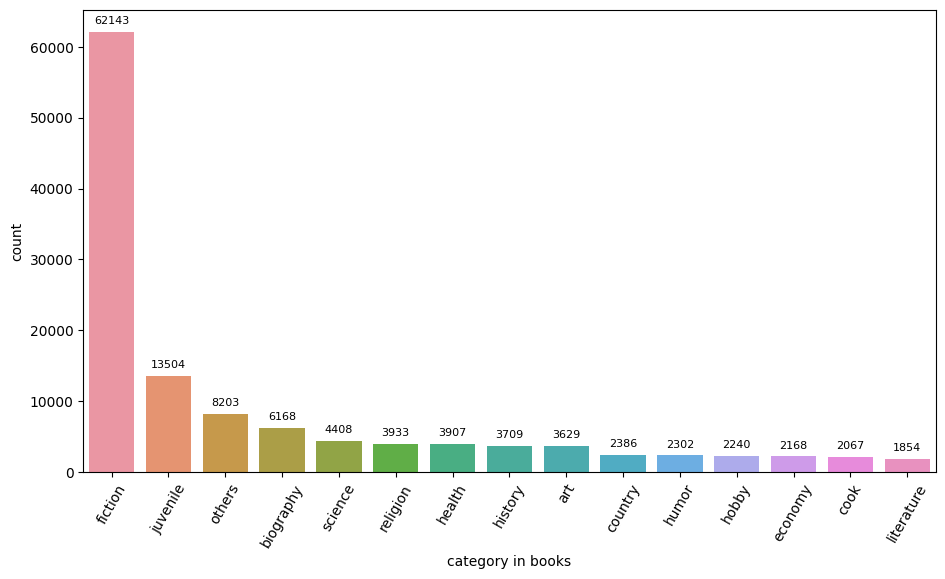

In [93]:
fig, ax= plt.subplots(1,1, figsize=(11,6))
ax = ax
my_dict= books['high_category'].value_counts().to_dict() #학습셋 내 범주 분포
count= pd.DataFrame(list(my_dict.items()),columns = ['category in books','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15) #많은 국가 15개만
sns.barplot(y = 'count',x= 'category in books' , data = f, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.show()

In [94]:
import os
if not os.path.isfile('/opt/ml/input/code/books_fillna_cate.csv'):
	books.to_csv('/opt/ml/input/code/books_fillna_cate.csv', index=False)